# Task 3, option one - Attacking Hiding

### 1. Setup functions

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

# AES SBOX
sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
    ], dtype='uint8')

# Hamming weight lookup table
hw_table = []
for i in range(256):
    s = '{0:08b}'.format(i)
    hw_table.append(s.count('1'))
hw_table = np.array(hw_table, 'uint8')

# Correlation of two matrices
def correlate(x, y):
    """
    Correlate all columns from matrix x of shape (a,b)
    with all columns from matrix y of shape (a,c),
    creating correlation matrix C of shape (b,c).
    
    Originally matlab script by Jiri Bucek in NI-HWB.
    """
    x = x - np.average(x, 0) # remove vertical averages
    y = y - np.average(y, 0) # remove vertical averages
    C = x.T @ y              # (n-1) Cov(x,y)
    C = C / (np.sum(x**2, 0)**(1/2))[:,np.newaxis] # divide by (n-1) Var(x)
    C = C / (np.sum(y**2, 0)**(1/2))               # divide by (n-1) Var(y)
    return C

# Load PT of CT from file
def load_text(file_name):
    """
    Load any text PT/CT from file containing hex strings with bytes 
    separated by spaces, one block per line
    Output is a matrix of bytes (np.array)
    """
    txt_str = open(file_name).readlines()
    del txt_str[-1] #discard last empty line
    #split each line into bytes and convert from hex
    txt_bytes_list = list(
        map(lambda line: 
                list(
                    map(lambda s: int(s, 16),
                        line.rstrip().split(" "))
                ),
            txt_str)
        )
    return np.array(txt_bytes_list, 'uint8')


def load_inputs_and_traces(prefix_path, len = None):
    # read plaintext inputs
    inputs = load_text(prefix_path + "/plaintext.txt")

    # read length of one complete trace (number of samples per trace)
    with open(prefix_path + "/traceLength.txt", "r") as fin:
        trace_length = int(fin.readline())

    # trim each trace - select interesting part
    start = 0
    if len == None:
        len = trace_length # CHANGE to the length of the first round; 

    # read traces from binary file
    traces = np.fromfile(prefix_path + "/traces.bin", dtype='uint8') # read as linear array
    traces = np.reshape(traces, (traces.size // trace_length, trace_length)) # reshape into matrix
    traces = traces[:, start:len] # select only the interesting part of each trace

    return inputs, traces
%matplotlib widget

### 2. Simple attack on the no triggered traces (ntt)
> Use trace alignment and compression to attack the card without trigger signal from the last lab. Use your own measurements. Path to dataset (just in case): (out of repo)/data/AES_no_trigger

In [4]:
from Crypto.Cipher import AES

ntt_inputs, ntt_traces = load_inputs_and_traces("aes_no_trigger_traces")
ntt_ciphertext = load_text("aes_no_trigger_traces/ciphertext.txt")
ntt_plaintextBlock = bytes(ntt_inputs[0])
ntt_ciphertextBlock = bytes(ntt_ciphertext[0])

def test_key(kk):
    key_bytes = bytes(kk)
    cipher = AES.new(key_bytes, AES.MODE_ECB)

    # Encrypting the plaintext using the cipher object
    encrypted_plaintext = cipher.encrypt(ntt_plaintextBlock)

    # Verifing that the encrypted plaintext matches the given ciphertext
    if encrypted_plaintext == ntt_ciphertextBlock:
        print("The key is valid !")
    else:
        print("Invalid key :(")

def display_correlation(corr, k):
    if k > 0  and k < 255:
        fig = plt.figure()
        plt.plot(corr[k+1])
        plt.plot(corr[k-1])
        plt.plot(corr[k])
        plt.show()
    else:
        print("k out of range for ploting")

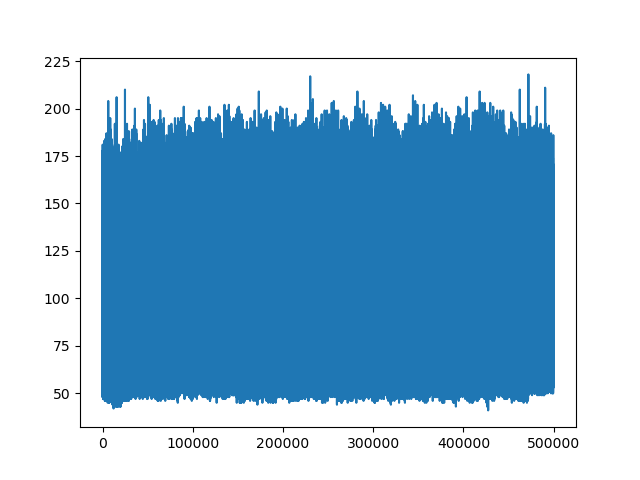

In [5]:
fig = plt.figure()
plt.plot(ntt_traces[1,255:])
plt.show()

In [21]:
def align_traces(traces, pattern):
    """
    Align a set of traces to a given pattern.
    Parameters
    ----------
    traces : array_like
    A 2D array where each row represents a separate trace.
    pattern : array_like
    A 1D array representing the pattern to align to.
    Returns
    -------
    aligned_traces : ndarray
    A 2D array where each row represents a separate trace, aligned to the pattern.
    """

    aligned_traces = np.zeros_like(traces)
    for i, trace in enumerate(traces):
        corr = signal.correlate(trace, pattern, mode="full")
        peak = np.argmax(corr)
        shift = peak
        aligned_traces[i] = np.roll(trace, shift)
    return aligned_traces

ntt_aligned_traces = align_traces(ntt_traces, np.copy(ntt_traces[0]))
ntt_aligned_traces.shape


(300, 499999)

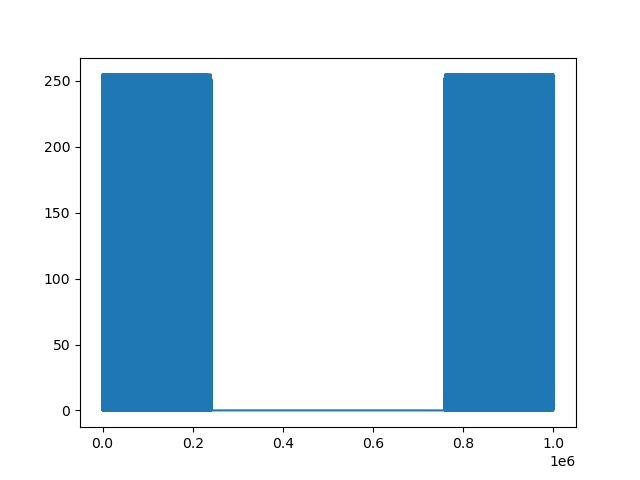

In [ ]:
aligned_traces = np.zeros_like(ntt_traces)
trace = ntt_traces[1]
pattern = ntt_traces[0]
corr = signal.correlate(trace, pattern)
fig = plt.figure()
plt.plot(corr)
plt.show()
peak = np.argmax(corr)
shift = pattern.size - peak
aligned_traces[i] = np.roll(trace, shift)

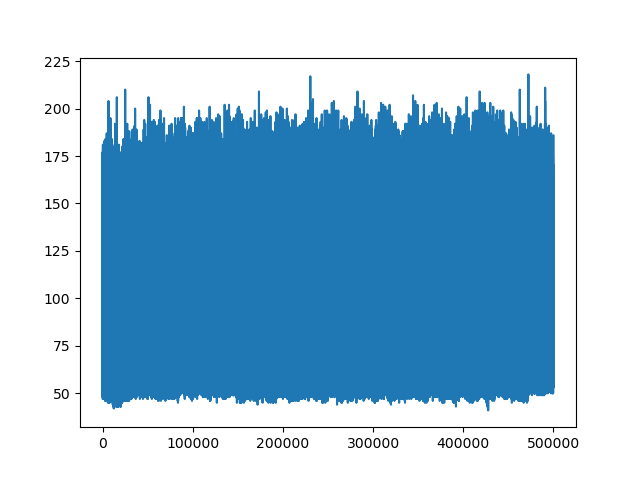

In [24]:
fig = plt.figure()
plt.plot(ntt_aligned_traces[1])
plt.show()

In [19]:
compressed_ntt_traces = ntt_aligned_traces[:,0:499998].reshape([300,83333,6]).mean(axis=2, dtype=np.float32)
compressed_ntt_traces.shape

(300, 83333)

In [22]:
kk = np.zeros(16, dtype='uint8')
keys = np.array(range(0, 256))

for l in range(1):
    print(f"range={l*50000}:{l*50000+50000}")
    for i in range(0, 16):
        inp = ntt_inputs[:, i]
        # XOR each data byte with each key
        xmat = inp[:, np.newaxis] ^ keys
        # Substitute with SBOX all XORed values -- matrix of intermediate values
        smat = sbox[xmat]
        # Compute Hamming Weights -- the matrix of hypothetical power consumption
        hmat = hw_table[smat]
        # Find correlation between hamming weights and traces
        # corr = correlate(hmat, ntt_aligned_traces)
        corr = correlate(hmat, compressed_ntt_traces)
        # Display first key byte correlation trace
        acorr = abs(corr)
        # Find the most correlated key and store it in the corr_table
        max_acorr = acorr.max()
        (k, j) = np.where(acorr == max_acorr) # find indices of maximum
        kk[i] = k
        # print("%1c, %02x @ %d" % (k[0], k[0], j[0]))
    test_key(kk)
correct_key = kk

range=0:50000
Invalid key :(
